## Assignment 1 Model Fitting with Maximum Likelihood 
* The purpose of this assignment is to learn how to write a log likelihood function, fit models to data with maximum likelihood and to select among models using AIC and a validation set.  
* Along the way, we'll learn a bit about decision making models and response time data.  

### Due: Sunday 10/19

In [6]:
import numpy as np
from matplotlib import pyplot as plt

### A Perceptual Discrimination Task to Study Decision Making

This is actual data from my lab, which was published here:

Nunez, M. D., Vandekerckhove, J., & Srinivasan, R. (2017). How attention influences perceptual decision making: Single-trial EEG correlates of drift-diffusion model parameters. Journal of Mathematical Psychology, 76(Part B), 117–130. https://doi.org/10.1016/j.jmp.2016.03.003

Human subject were asked to discriminate the spatial frequency of Gabor patches (as shown below), embeded in noise.  Task difficulty was controlled by the difficulty of the discrimination.  Two Gabors with more similar spatial frequencies are harder to discriminate, especially when noise is added.  In each of 34 participant, The experiment was performed in Easy, Medium, and Hard blocks each consisting of with decreasing differences between the Gabor spatial frequencies.  

![](spatialfrequency.png)

The datafile ReactionTimeData.csv is for use in this homework. You can load it into your notebook using pandas using pandas. There are 3 variables in the file: 

* Subject - indicates a numeric subject id 
* Experimental Condition - Easy, Medium, Hard 
* Correct - 1 if correct 0 if incorrect 
* ResponseTime  - time from stimulus presentation to decision in units of millisecond 

#### Problem 1 Explore and Visualize the Data.  I recommend using this exercise to learn about seaborn. 
a. make a histogram of Response Time showing all 3 difficulty conditions in a single graph.
 
 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


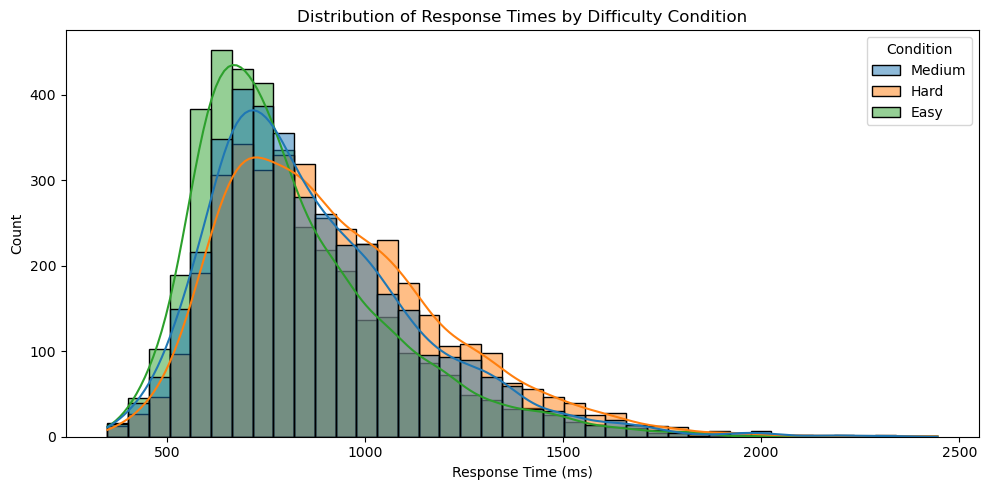

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("ResponseTimeData.csv")

plt.figure(figsize=(10, 5))
sns.histplot(
    data=df,
    x="ResponseTime",
    hue="Condition",
    bins=40,
    kde=True,
    alpha=0.5
)

plt.title("Distribution of Response Times by Difficulty Condition")
plt.xlabel("Response Time (ms)")
plt.ylabel("Count")
plt.tight_layout() 
plt.show()


b. make a bar graph showing the accuracy (proportion or percentage correct) in each condition.  

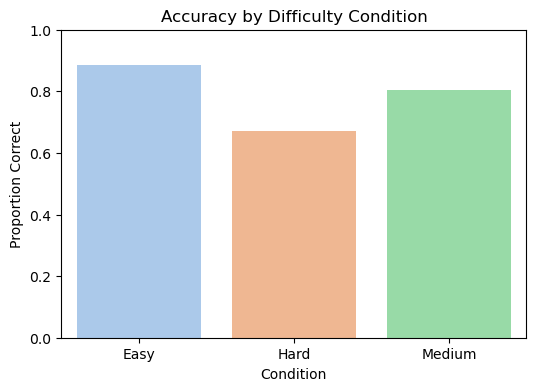

In [2]:
accuracy = df.groupby("Condition")["Correct"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=accuracy, x="Condition", y="Correct", palette="pastel")

plt.title("Accuracy by Difficulty Condition")
plt.ylabel("Proportion Correct")
plt.ylim(0, 1)
plt.show()


c. Make a boxplot that shows the distributions of each condition, with correct and incorrect trials separated. 

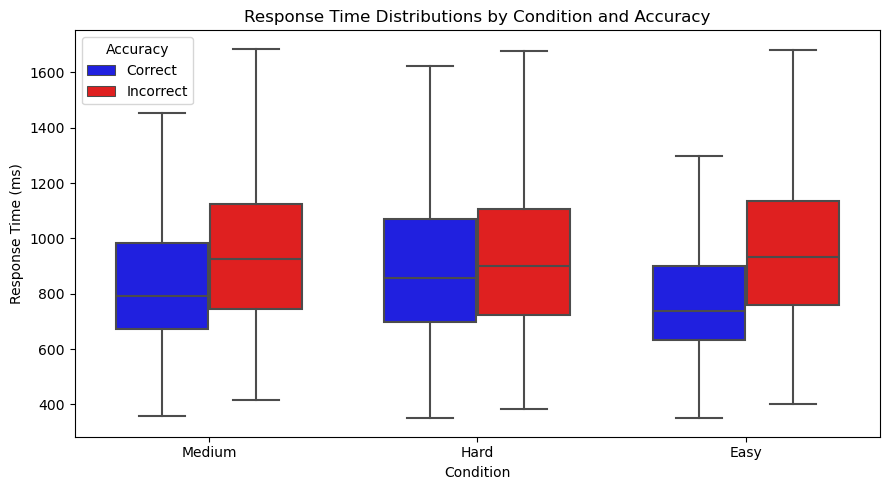

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("ResponseTimeData.csv")

# Create explicit string labels so hue categories are clear
df['AccuracyLabel'] = df['Correct'].map({0: 'Incorrect', 1: 'Correct'})

# Define colors explicitly (you can change hex codes)
palette = {'Incorrect': 'red', 'Correct': 'blue'}

plt.figure(figsize=(9,5))
sns.boxplot(
    data=df,
    x="Condition",
    y="ResponseTime",
    hue="AccuracyLabel",
    width=0.7,   
    palette=palette,
    showfliers=False  # optional: hide extreme outliers for clarity
)

plt.title("Response Time Distributions by Condition and Accuracy")
plt.ylabel("Response Time (ms)")
plt.xlabel("Condition")
plt.legend(title="Accuracy")     # legend will match palette mapping
plt.tight_layout()
plt.show()


d. Calculate the mean reaction time for each subject in each condition.  Make a histogram that shows the distribution of mean RT across subjects,showing all 3 conditions in a single graph. 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


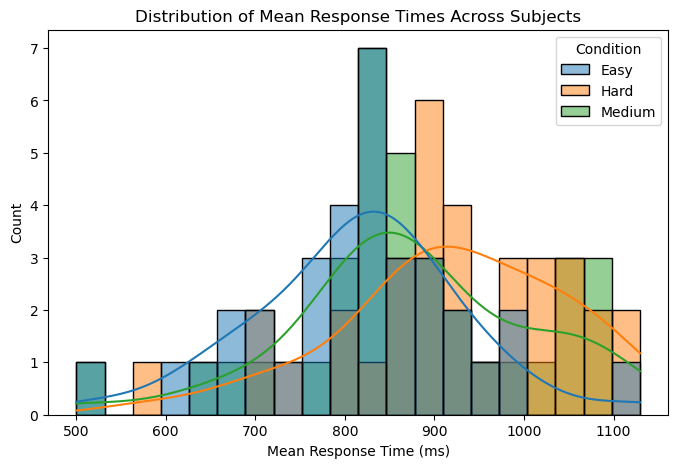

In [9]:
mean_rt = df.groupby(['Subject', 'Condition'])['ResponseTime'].mean().reset_index()

mean_rt.head()

plt.figure(figsize=(8,5))
sns.histplot(
    data=mean_rt,
    x='ResponseTime',
    hue='Condition',
    bins=20,
    kde=True,
    alpha=0.5
)
plt.title('Distribution of Mean Response Times Across Subjects')
plt.xlabel('Mean Response Time (ms)')
plt.ylabel('Count')
plt.show()


In class we discussed how different distributions might be used to model Response Time data in decision making tasks.  In particular, the shifted Wald distribution is a distribution that captures aspects of the processes that give rise to Response Time.  

The shifted Wald distribution is a 1-boundary model. And, for simplicity, we will only consider correct trials.  



In [10]:
def shiftedwald(params, x):
    '''
    params: is a list or numpy array containing two parameters
    x: are the data
    '''
 
    gamma = params[0] #drift rate
    alpha = params[1] #boundary separation
    theta = params[2] #shift or nondecision time 
    x = x-theta
    z = alpha/np.sqrt(2*np.pi*(x**3))
    w = ((np.abs(alpha-gamma*x))**2)/(2*x)
    f = z*np.exp(-w)
    return f

### Problem 2 
Use the shifted Wald distribution defined above.  Write a function which computes the negative log likelihood of the shifted Wald distribution.  Assume that the data to be analyzed is in a variable called data. 

The function should return negative log likelihood 

In [11]:
def shiftedwald(params, x):
    """
    Shifted Wald / ex-Wald PDF

    params: list or array with three parameters
        gamma: drift rate
        alpha: boundary separation
        theta: non-decision time (shift)
    x: array of observed reaction times
    """
    gamma, alpha, theta = params
    x_shifted = x - theta
    x_shifted = np.maximum(x_shifted, 1e-10)
    
    z = alpha / np.sqrt(2 * np.pi * x_shifted**3)
    w = ((alpha - gamma * x_shifted)**2) / (2 * x_shifted)
    f = z * np.exp(-w)
    return f

def neg_log_likelihood(params, data):
    """
    Computes the negative log likelihood of the shifted Wald distribution.

    params: list or array with three parameters
        gamma: drift rate
        alpha: boundary separation
        theta: non-decision time (shift)
    data: array of observed reaction times
    """
    pdf_vals = shiftedwald(params, data)
    # Avoid log(0)
    pdf_vals = np.maximum(pdf_vals, 1e-12)
    nll = -np.sum(np.log(pdf_vals))
    return nll

def negloglikeWald(params, data):
    """
    Negative log likelihood function suitable for optimizers.
    params: [gamma, alpha, theta]
    data: array of reaction times
    """
    return neg_log_likelihood(params, data)


### Problem 3 

Using the function the negative log-likelihood that you developed in problem 1, fit the shifted Wald distribution to the data for ALL the subjects in ReactionTimeData.csv.  

You should consider two models: 
Model A: All of the data comes from a single distribution. 
Model B: The data in each condition (Easy, Medium, Hard) comes from a separate distribution. 

When providing bounds to the fitting process, keep in mind that the only constraints on the parameters of this model is that they have to be positive.  To specify an upper bound of infinity, use `np.inf`

If you run into problems with your computer taking too long, reduce the amount of data, even do just 1 or a few subjects.

Make a plot or table or something to show me (make it pretty!) how the resulting parameter fits turned out.  

Fitting Model A (all data)...
Fitting Model B (by condition)...

RESULTS

Model A (all data): γ=3.094, α=2.146, θ=0.175
  AIC = 19.2

Model B (by condition):
  Easy: γ=3.154, α=1.874, θ=0.219
  Medium: γ=3.191, α=2.297, θ=0.152
  Hard: γ=3.173, α=2.544, θ=0.119
  AIC = -316.8

ΔAIC = 336.0
Better model: B

Plot saved as 'wald_results.png'


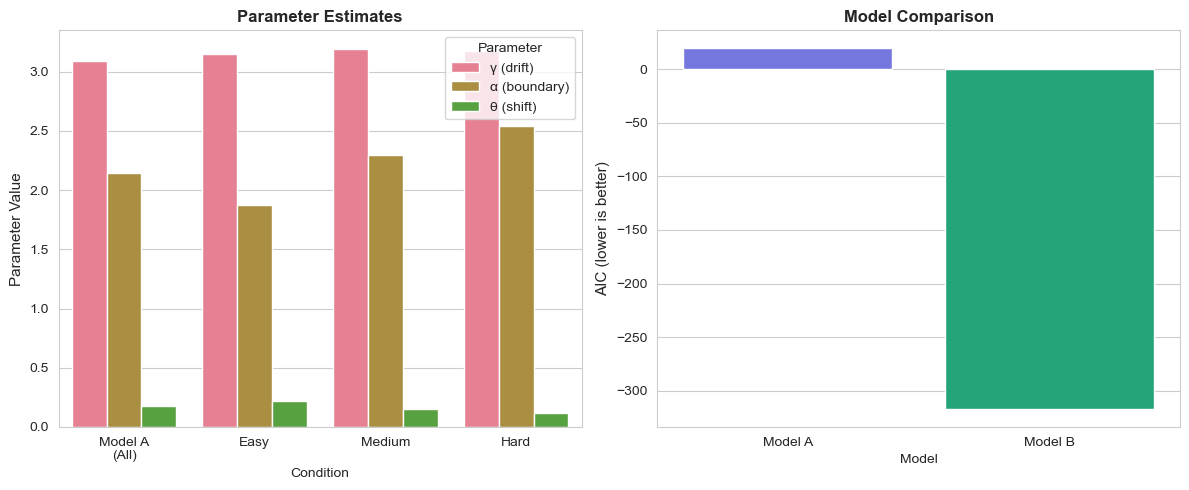

In [12]:
from scipy.optimize import minimize

sns.set_style("whitegrid")
sns.set_palette("husl")


df['rt'] = df['ResponseTime'] / 1000.0  # Convert to seconds

# MODEL A: Fit all data together
print("Fitting Model A (all data)...")
result_A = minimize(negloglikeWald, [2.0, 0.3, 0.2], args=(df['rt'].values,),
                    method='L-BFGS-B', bounds=[(1e-6, np.inf)] * 3)
gamma_A, alpha_A, theta_A = result_A.x
nll_A = result_A.fun
aic_A = 2 * 3 + 2 * nll_A

# MODEL B: Fit each condition separately
print("Fitting Model B (by condition)...")
results_B = {}
nll_B_total = 0

for condition in ['Easy', 'Medium', 'Hard']:
    data = df[df['Condition'] == condition]['rt'].values
    result = minimize(negloglikeWald, [2.0, 0.3, 0.2], args=(data,),
                     method='L-BFGS-B', bounds=[(1e-6, np.inf)] * 3)
    results_B[condition] = {'gamma': result.x[0], 'alpha': result.x[1], 'theta': result.x[2]}
    nll_B_total += result.fun

aic_B = 2 * 9 + 2 * nll_B_total

# Print results
print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"\nModel A (all data): γ={gamma_A:.3f}, α={alpha_A:.3f}, θ={theta_A:.3f}")
print(f"  AIC = {aic_A:.1f}")

print(f"\nModel B (by condition):")
for cond in ['Easy', 'Medium', 'Hard']:
    r = results_B[cond]
    print(f"  {cond}: γ={r['gamma']:.3f}, α={r['alpha']:.3f}, θ={r['theta']:.3f}")
print(f"  AIC = {aic_B:.1f}")

print(f"\nΔAIC = {aic_A - aic_B:.1f}")
print(f"Better model: {'B' if aic_B < aic_A else 'A'}")

# Create dataframes for seaborn plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Parameters by condition
param_data = []
conditions = ['Model A\n(All)', 'Easy', 'Medium', 'Hard']
gammas = [gamma_A] + [results_B[c]['gamma'] for c in ['Easy', 'Medium', 'Hard']]
alphas = [alpha_A] + [results_B[c]['alpha'] for c in ['Easy', 'Medium', 'Hard']]
thetas = [theta_A] + [results_B[c]['theta'] for c in ['Easy', 'Medium', 'Hard']]

for i, cond in enumerate(conditions):
    param_data.append({'Condition': cond, 'Parameter': 'γ (drift)', 'Value': gammas[i]})
    param_data.append({'Condition': cond, 'Parameter': 'α (boundary)', 'Value': alphas[i]})
    param_data.append({'Condition': cond, 'Parameter': 'θ (shift)', 'Value': thetas[i]})

param_df = pd.DataFrame(param_data)
sns.barplot(data=param_df, x='Condition', y='Value', hue='Parameter', ax=ax1)
ax1.set_ylabel('Parameter Value', fontsize=11)
ax1.set_title('Parameter Estimates', fontsize=12, fontweight='bold')
ax1.legend(title='Parameter')

# Plot 2: Model comparison
model_df = pd.DataFrame({
    'Model': ['Model A', 'Model B'],
    'AIC': [aic_A, aic_B]
})
sns.barplot(data=model_df, x='Model', y='AIC', ax=ax2, palette=['#6366f1', '#10b981'])
ax2.set_ylabel('AIC (lower is better)', fontsize=11)
ax2.set_title('Model Comparison', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('wald_results.png', dpi=150, bbox_inches='tight')
print("\nPlot saved as 'wald_results.png'")
plt.show()

### Problem 4 

Use AIC to evaluate which model you should prefer.  Do the data come from 1 distribution or from three different distributions?  

### Problem 5 

The two models given above are not the only models we could propose. The power of likelihood and modeling (as opposed to statistical testing) is if we can be very specific about our hypothesis.    

The original idea of this experiment was to manipulate drift rate in order to find brain activity related to speed of information processing. 
So, our hypothesis was that non-decision time, and boundary would be the same for all conditions, and only the drift rate would vary.  

Write a function for negative log likelihood for a model that keeps boundary (alpha) and non-decision time (theta) the same for all 3 conditions, but allows drift rate (gamma) to vary between conditions. 

In this model there are now 5 parameters - gamma_easy, gamma_medium, gamma_hard, alpha, theta. 
The likelihood should be evaluated using the correct gamma for each condition, and using the sama alpha and theta for all condition.  

### Problem 6

Use you new likelihood you developed in Problem 5 to fit the data (call it model C), and compare to models A and B using AIC. Make a new table showing the parameters for each model and which model seems to fit the data the best. (by AIC)   

### Problem 7 (Experimental) - not required.  

Use sklearn's test_train_split to split the dataframe you read from ResponseTime.csv into training and test dataframes.  Keep around 0.2 or 0.3 of the data for testing.  When you do this, remember to stratify by participant!  Fit models A,B,C to the training data.  Then choose the best parameter values for each model to compute the likelihood of each model and identify which model has maximum likelihood in the test data. No AIC needed!   